<a href="https://colab.research.google.com/github/pjseoane/AlgoTrading/blob/master/Packs_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from pandas_datareader import data as pdr
#https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

import collections

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
#>>> datetime.today().strftime('%Y-%m-%d')
#'2021-01-26'

In [13]:
!pip install yfinance

In [14]:
import yfinance as yf
#https://pypi.org/project/yfinance/
yf.pdr_override() # <== that's all it takes :-)

In [87]:
class cNewPack():
  def __init__(self, pack_dictionary,start_date,end_date):
    
    self.pack_dictionary=pack_dictionary
    self.start_date=start_date
    self.end_date=end_date

    self.totalPack=sum(self.pack_dictionary.values())

    #ordena el diccionario de entrada para ser compatible con el dataframe generado por Yahoo
    sortedPack=collections.OrderedDict(sorted(self.pack_dictionary.items())) 
    sortedTupleKeys=list(sortedPack.keys())
    sortedTupleValues=list(sortedPack.values())
    CCL=['GGAL.BA','GGAL']

    #consulta la API de yahoo con los datos del pack y los datos de las acciones para CCL
    self.panel_stocks = pdr.get_data_yahoo(sortedTupleKeys, start=self.start_date, end=self.end_date)
    self.panel_CCL=pdr.get_data_yahoo(CCL, start=self.start_date, end=self.end_date)
    #self.panel_CCL['FX']=self.panel_CCL.Close['GGAL.BA']*10/self.panel_CCL.Close['GGAL']

    #Arma otro panda solo con los Close y lo valoriza por cantidades,agrega una col con el total en USD    
    self.panel_stocks_wgt=self.panel_stocks.Close * sortedTupleValues
    self.panel_stocks_wgt['Pack_USD']=self.panel_stocks_wgt.sum(axis=1)

    #Agrega una columna con los datos de CCL
    #self.panel_stocks_wgt['CCL']=self.panel_CCL.FX
    self.panel_stocks_wgt['CCL']=self.panel_CCL.Close['GGAL.BA']*10/self.panel_CCL.Close['GGAL']

    #para llenar los gaps
    self.panel_normalized=self.panel_stocks_wgt.ffill().bfill()

    #Agrega una columna con el total del pack en pesos
    self.panel_normalized['Pack_ARS']=self.panel_normalized.Pack_USD*self.panel_normalized.CCL

  #1
  def getPackEvolution(self):
    return self.panel_normalized

  #2
  def getPanelCCL(self):
    return self.panel_normalized.CCL

  #3
  def getPanelStocks(self):
    return self.panel_stocks

  #4
  def getPackPlot(self):
    #https://www.geeksforgeeks.org/how-to-add-a-y-axis-label-to-the-secondary-y-axis-in-matplotlib/
    
    y1=self.panel_normalized['Pack_ARS']
    y2=self.panel_normalized['CCL']
    fig, ax=plt.subplots(figsize = (10, 5))
    plt.title('Packs vs CCL')

    ax.set_xlabel('Fechas', color = 'r')
    ax2=ax.twinx()
    ax.set_ylabel('Pack ARS', color = 'g')
    ax2.set_ylabel('CCL', color = 'b')
    
    ax.plot(y1,color='g')
    ax2.plot(y2,color='b')

    plt.tight_layout()
    plt.show()

    return

  #5
  def writePanel_to_CSV(self):
    self.panel_normalized.to_csv('pack table', index=None)
    return

  #6
  def getCorrelationMatrix(self):
    return self.panel_stocks.Close.corr()

  def getStocksRecommendation(self):
    #arma un dict con toda la info de las empresas
    dict_info={}
    for key,values in self.pack_dictionary.items():
      try:
        dict_info[key]=yf.Ticker(key).info
      except:
        exit

    dict_calificaciones={}
    for key,values in self.pack_dictionary.items():
      try:
        dict_calificaciones[key]=dict_info[key]['recommendationMean']
      
      except:
        exit
    return dict_calificaciones


  def getPackCalification(self):
    recomendWgt=0
    dict_calific=self.getStocksRecommendation()

    for key,values in self.pack_dictionary.items():
      try:
        recomendWgt+=self.pack_dictionary[key]* dict_calific[key]
      except:
        exit
    
    return (recomendWgt/self.totalPack)

  def getTotalPack(self):
    return self.totalPack

  


In [94]:
Pack_5G_dict={'AAPL': 8/10,'QCOM': 8/11, 'ADI': 2/3, 'AMD': 1/0.5}
start_date = '2021-05-07'
#end_date = '2021-08-10'
end_date=datetime.today().strftime('%Y-%m-%d')
Pack_5G=cNewPack(Pack_5G_dict,start_date,end_date)

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  2 of 2 completed


In [64]:
Pack_5G.getPackEvolution()

,AAPL,ADI,AMD,QCOM,SPY,Pack_USD,CCL,Pack_ARS
Date,,,,,,,,
2021-05-07,104.168005,104.839996,157.619995,100.254550,0.0,466.882547,156.780734,73198.188316
2021-05-10,101.479999,100.526662,151.979996,93.774547,0.0,447.761204,156.863983,70237.605685
2021-05-11,100.728003,100.559998,153.660004,93.359996,0.0,448.308001,156.369429,70101.665914
2021-05-12,98.215997,97.366669,149.279999,90.632729,0.0,435.495394,156.241873,68042.616219
2021-05-13,99.976001,97.753337,146.179993,92.443637,0.0,436.352967,157.537690,68742.038281
...,...,...,...,...,...,...,...,...
2021-08-03,117.888000,112.453328,225.119995,107.599998,0.0,563.061322,181.546132,102221.605008
2021-08-04,117.559998,115.053335,237.539993,107.796365,0.0,577.949690,180.339199,104226.984114
2021-08-05,117.647998,113.286662,224.699997,106.785456,0.0,562.420113,179.938263,101200.898221


In [65]:
Pack_5G.getPanelCCL()

Date
2021-05-07    156.780734
2021-05-10    156.863983
2021-05-11    156.369429
2021-05-12    156.241873
2021-05-13    157.537690
                 ...    
2021-08-03    181.546132
2021-08-04    180.339199
2021-08-05    179.938263
2021-08-06    177.101088
2021-08-09    176.219516
Name: CCL, Length: 65, dtype: float64

In [66]:
Pack_5G.getPanelStocks()

Adj Close                          ...     Volume                     
                  AAPL         ADI         AMD  ...        AMD      QCOM        SPY
Date                                            ...                                
2021-05-07  130.015213  156.597870   78.809998  ...   36954200   6893700   67733800
2021-05-10  126.660225  150.155106   75.989998  ...   45134500  19537200   81852400
2021-05-11  125.721642  150.204895   76.830002  ...   51008200  11948000  116888000
2021-05-12  122.586334  145.435074   74.639999  ...   42531400  13529600  134811000
2021-05-13  124.783043  146.012634   73.089996  ...   48646800  10633000  106394000
...                ...         ...         ...  ...        ...       ...        ...
2021-08-03  147.139542  168.679993  112.559998  ...  157723100   6223400   58053900
2021-08-04  146.730164  172.580002  118.769997  ...  225368700   5556400   46732200
2021-08-05  146.839996  169.929993  112.349998  ...  137860900   7169200   38969700
2021-08-06  146.139999  171.130005  110.110001  ...  143792800   5732300   46864100
2021-08-09  146.089996  171.309998  107.580002  ...  115749900   4966600   41222600

[65 rows x 30 columns]

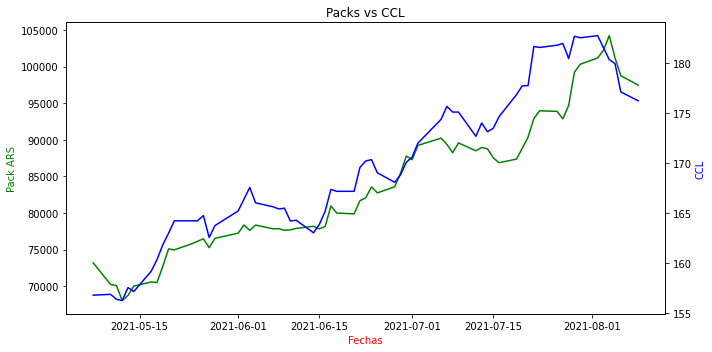

In [67]:
Pack_5G.getPackPlot()

In [68]:
Pack_5G.writePanel_to_CSV()

In [95]:
Pack_5G.getCorrelationMatrix()

,AAPL,ADI,AMD,QCOM
AAPL,1.000000,0.471617,0.795969,0.884483
ADI,0.471617,1.000000,0.645411,0.710675
AMD,0.795969,0.645411,1.000000,0.913905
QCOM,0.884483,0.710675,0.913905,1.000000


In [ ]:
Pack_5G.getPanelCCL()

In [ ]:
Pack_5G.getPanelStocks()

In [ ]:
Pack_5G.getPackPlot()

In [26]:
Pack_5G.getCorrelationMatrix()

,AAPL,ADI,AMD,QCOM,SPY
AAPL,1.000000,0.461108,0.792664,0.882171,0.924201
ADI,0.461108,1.000000,0.635945,0.703924,0.664643
AMD,0.792664,0.635945,1.000000,0.912365,0.863950
QCOM,0.882171,0.703924,0.912365,1.000000,0.946136
SPY,0.924201,0.664643,0.863950,0.946136,1.000000


In [96]:
%time Pack_5G.getStocksRecommendation()

CPU times: user 1.01 s, sys: 32.7 ms, total: 1.04 s
Wall time: 8.28 s


{'AAPL': 2, 'ADI': 1.7, 'AMD': 2.3, 'QCOM': 2}

In [98]:
%time Pack_5G.getPackCalification()

CPU times: user 1.12 s, sys: 37.8 ms, total: 1.16 s
Wall time: 15.5 s


2.095375722543353

In [37]:
Pack_IAv1={'NVDA': 12/24,'FB': 2/8, 'GOOGL': 2/58, 'AMZN': 3/144}
start_date = '2021-05-14'
datetime.today().strftime('%Y-%m-%d')
Pack_IAv1=cNewPack(Pack_IAv1,start_date,end_date)

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  2 of 2 completed


In [ ]:
Pack_IAv1.getPackEvolution()

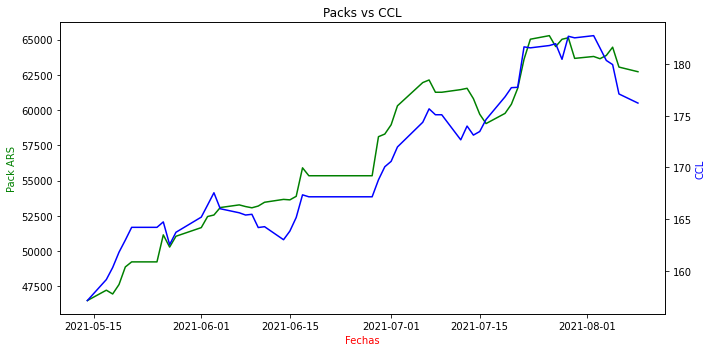

In [28]:
Pack_IAv1.getPackPlot()

In [39]:
Pack_IAv1.getTotalPack()

0.805316091954023

In [30]:
print(yf.Ticker('NVDA').info['recommendationMean'])
print(yf.Ticker('FB').info['recommendationMean'])
print(yf.Ticker('GOOGL').info['recommendationMean'])
print(yf.Ticker('AMZN').info['recommendationMean'])

1.9
1.8
1.7
1.7


In [40]:
Pack_IAv1.getPackCalification()

1.8552185548617306

In [57]:
tickerStrings = ['AAPL', 'MSFT']
df = yf.download(tickerStrings, group_by='Ticker', period='2d')
df = df.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1)
df[df['Ticker']=='AAPL']

[*********************100%***********************]  2 of 2 completed


,Ticker,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2021-08-09,AAPL,146.089996,146.089996,146.699997,145.520004,146.199997,48908700
2021-08-10,AAPL,145.600006,145.600006,147.710007,145.300003,146.440002,66428124


In [52]:
df[df.Ticker='AAPL']

SyntaxError: ignored